In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Obtener los enlaces de los archivos Parquet
url = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

parquet_files = []
selected_years = ['2021']

for link in soup.find_all('a', href=True):
    if link['href'].endswith('.parquet') and any(year in link['href'] for year in selected_years):
        parquet_files.append(link['href'])

# Filtrar archivos que contengan 'fhvhv_tripdata'
high_volume_fhv = [link for link in parquet_files if 'fhvhv_tripdata' in link]

# Procesar cada archivo Parquet y crear dataframes
dataframes = []
for parquet_file in high_volume_fhv:
    df = pd.read_parquet(parquet_file)
    df = df[df['pickup_datetime'].dt.year.isin([2021])]  # Filtrar solo el año 2021
    
    # Eliminar filas con valores nulos
    df = df.dropna(subset=['pickup_datetime', 'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'base_passenger_fare', 'tips', 'driver_pay'])
    
    # Eliminar duplicados
    df = df.drop_duplicates()

    df['date'] = df['pickup_datetime'].dt.date
    df_agrupada = df.groupby(['date', 'hvfhs_license_num', 'PULocationID', 'DOLocationID']).agg({
        'trip_miles': 'sum',
        'trip_time': 'sum',
        'base_passenger_fare': 'sum',
        'tips': 'sum',
        'driver_pay': 'sum'
    }).reset_index()

    # Mapeo de hvfhs_license_num a nombres de compañías
    df_agrupada['hvfhs_company'] = df_agrupada['hvfhs_license_num'].replace({
        'HV0002': 'Juno',
        'HV0003': 'Uber',
        'HV0004': 'Via',
        'HV0005': 'Lyft'
    })

    # Reemplazar hvfhs_license_num por hvfhs_company
    df_agrupada = df_agrupada.drop(columns=['hvfhs_license_num'])
    df_agrupada = df_agrupada.rename(columns={'hvfhs_company': 'hvfhs_license_num'})

    dataframes.append(df_agrupada)

# Concatenar todos los dataframes en uno solo
if dataframes:
    full_df = pd.concat(dataframes, ignore_index=True)
    
    # Eliminar nulos y duplicados del DataFrame final
    full_df = full_df.dropna()
    full_df = full_df.drop_duplicates()
    
    print("DataFrame final creado exitosamente.")
else:
    full_df = pd.DataFrame()
    print("No se encontraron datos para procesar.")

DataFrame final creado exitosamente.


In [3]:
full_df 

,date,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tips,driver_pay,hvfhs_license_num
0,2021-01-01,2,181,11.020,2407,46.44,0.00,32.58,Uber
1,2021-01-01,3,3,52.860,13549,336.67,3.76,284.84,Uber
2,2021-01-01,3,7,25.560,3934,100.95,0.00,76.54,Uber
3,2021-01-01,3,18,97.960,24503,487.42,2.82,373.61,Uber
4,2021-01-01,3,20,62.590,14135,276.95,10.34,215.38,Uber
...,...,...,...,...,...,...,...,...,...
20106689,2021-12-31,265,203,1.246,296,8.27,0.00,5.47,Lyft
20106690,2021-12-31,265,241,6.179,1056,19.86,0.00,15.70,Lyft
20106691,2021-12-31,265,254,4.135,1400,28.53,0.00,16.31,Lyft
20106692,2021-12-31,265,259,1.031,412,9.15,0.00,5.47,Lyft


In [4]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20106694 entries, 0 to 20106693
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   date                 object 
 1   PULocationID         int64  
 2   DOLocationID         int64  
 3   trip_miles           float64
 4   trip_time            int64  
 5   base_passenger_fare  float64
 6   tips                 float64
 7   driver_pay           float64
 8   hvfhs_license_num    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 1.3+ GB


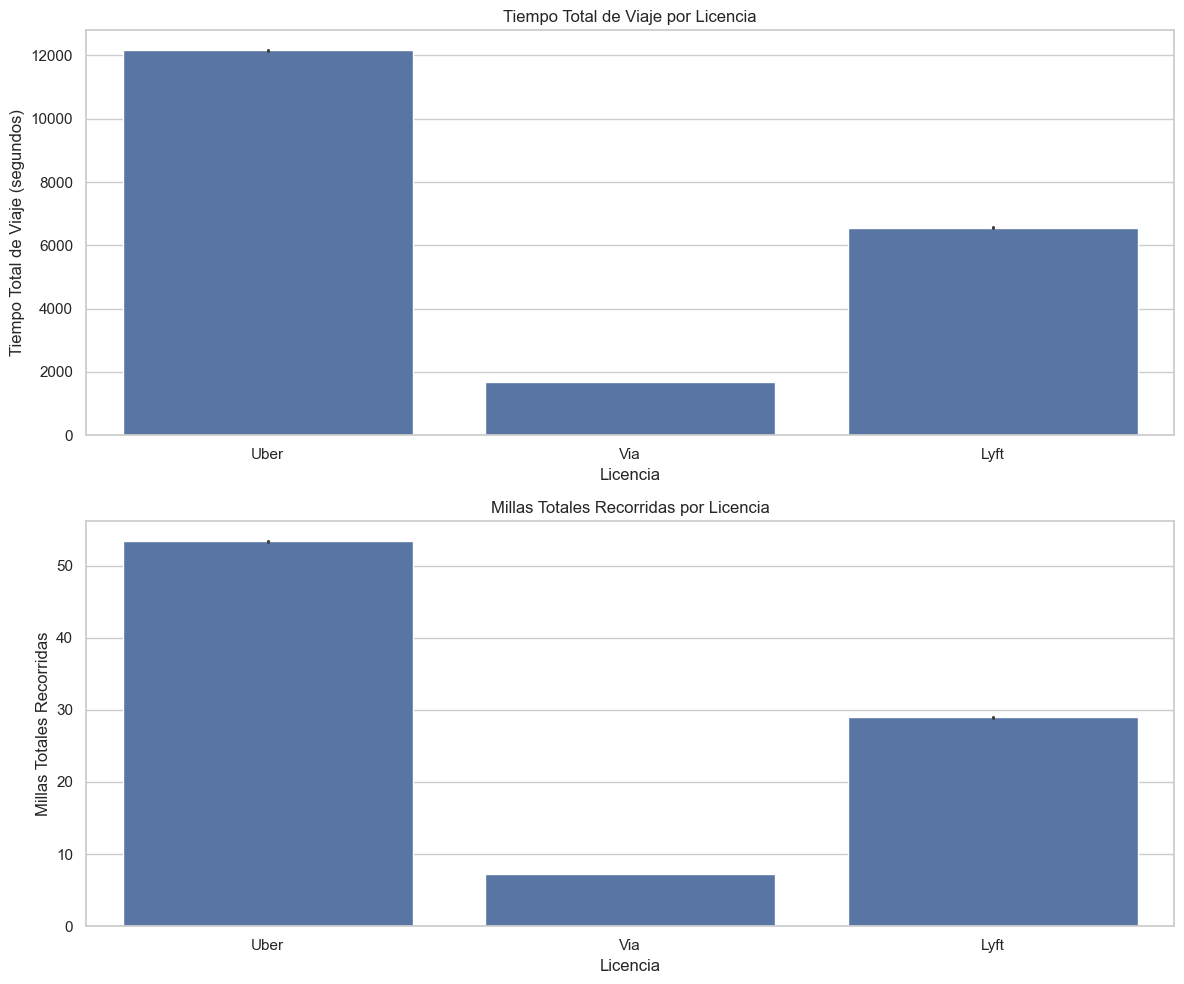

In [5]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Graficar el tiempo de viaje por hvfhs_license_num
sns.barplot(x='hvfhs_license_num', y='trip_time', data=full_df, ax=axes[0])
axes[0].set_title('Tiempo Total de Viaje por Licencia')
axes[0].set_xlabel('Licencia')
axes[0].set_ylabel('Tiempo Total de Viaje (segundos)')

# Graficar las millas recorridas por hvfhs_license_num
sns.barplot(x='hvfhs_license_num', y='trip_miles', data=full_df, ax=axes[1])
axes[1].set_title('Millas Totales Recorridas por Licencia')
axes[1].set_xlabel('Licencia')
axes[1].set_ylabel('Millas Totales Recorridas')

# Ajustar el diseño de los subgráficos
plt.tight_layout()

# Mostrar las gráficas
plt.show()

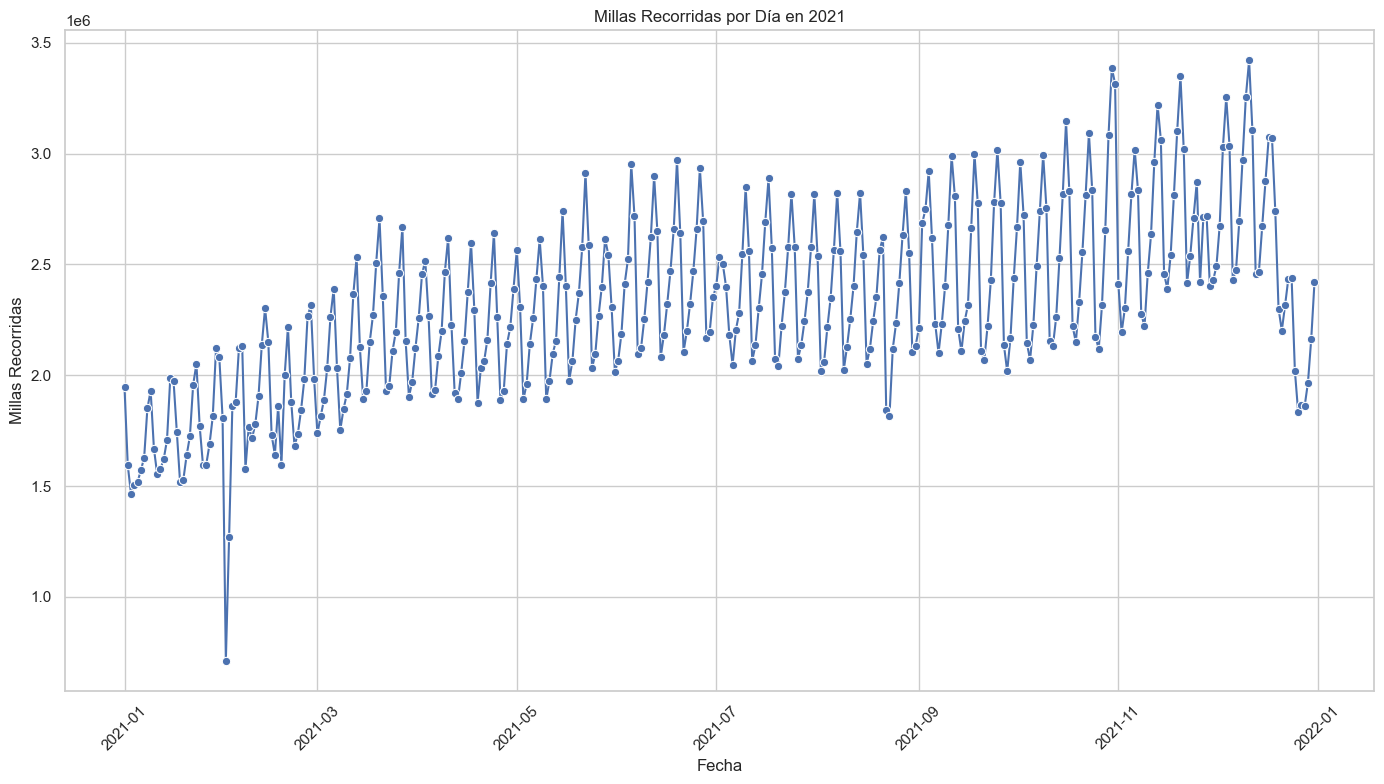

In [6]:
# Agrupar por fecha y calcular la suma de las millas recorridas por día
daily_miles = full_df.groupby('date')['trip_miles'].sum().reset_index()

# Convertir la columna 'date' a datetime
daily_miles['date'] = pd.to_datetime(daily_miles['date'])

# Crear una columna para el mes y el día del mes
daily_miles['month'] = daily_miles['date'].dt.to_period('M')
daily_miles['day'] = daily_miles['date'].dt.day

# Configuración del gráfico
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_miles, x='date', y='trip_miles', marker='o')
plt.title('Millas Recorridas por Día en 2021')
plt.xlabel('Fecha')
plt.ylabel('Millas Recorridas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [7]:
# Cargar el archivo de lookup de zonas de taxi
taxi_zones = pd.read_csv('taxi_zone_lookup.csv')

    LocationID                  Zone  TotalCount
0          132           JFK Airport    329337.0
1          138     LaGuardia Airport    313529.0
2           61   Crown Heights North    281391.0
5           75     East Harlem South    276661.0
4           37        Bushwick South    276134.0
3            7               Astoria    275804.0
7          140       Lenox Hill East    272770.0
8           42  Central Harlem North    265629.0
9           74     East Harlem North    261575.0
10          48          Clinton East    261029.0


C:\Users\castr\AppData\Local\Temp\ipykernel_17220\742155365.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_locations, x='Zone', y='TotalCount', palette='viridis')


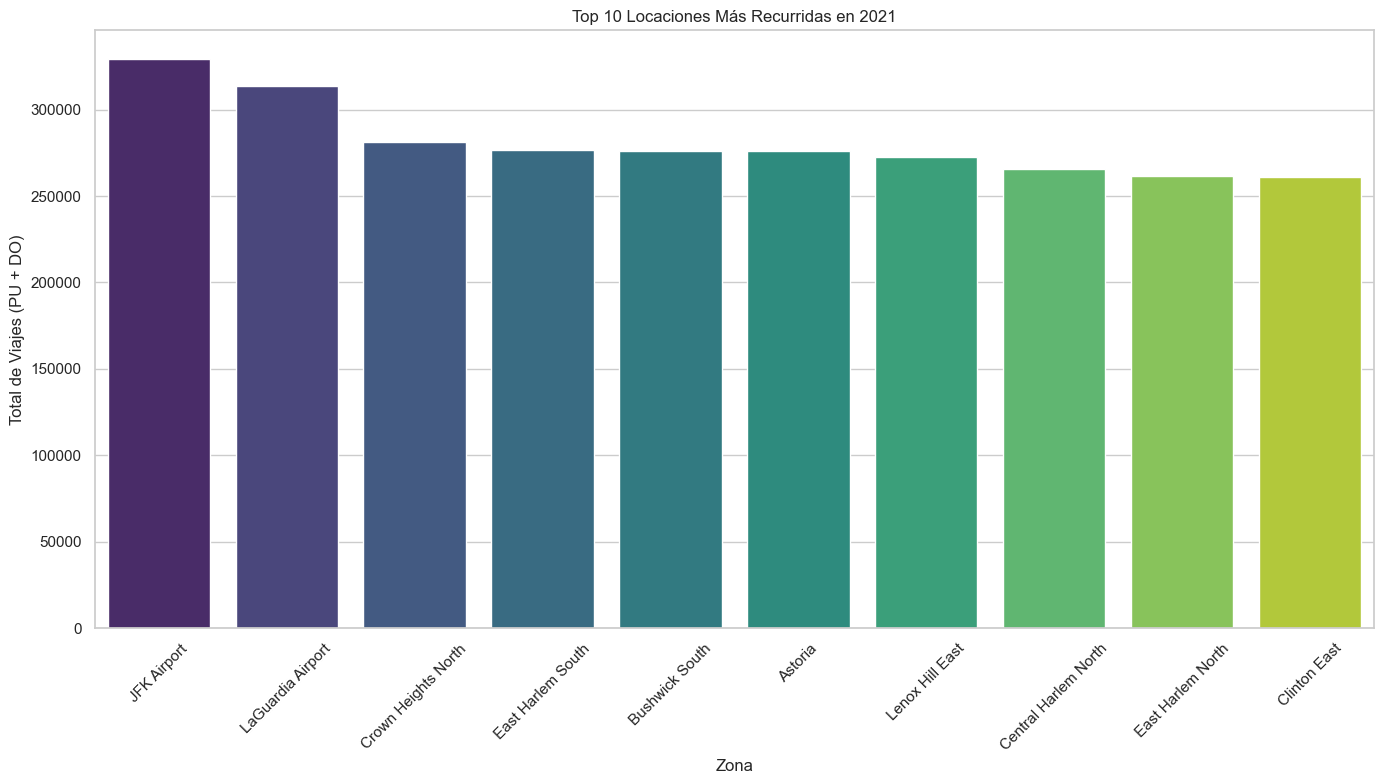

In [36]:
# Contar las ocurrencias de cada PULocationID y DOLocationID
pulocation_counts = full_df['PULocationID'].value_counts().reset_index()
dolocation_counts = full_df['DOLocationID'].value_counts().reset_index()

# Renombrar las columnas para claridad
pulocation_counts.columns = ['LocationID', 'PUCount']
dolocation_counts.columns = ['LocationID', 'DOCount']

# Unir los conteos con el archivo de lookup de zonas de taxi
location_counts = pd.merge(pulocation_counts, dolocation_counts, on='LocationID', how='outer').fillna(0)
location_counts['TotalCount'] = location_counts['PUCount'] + location_counts['DOCount']
location_counts = pd.merge(location_counts, taxi_zones, left_on='LocationID', right_on='LocationID', how='left')

# Ordenar por TotalCount
location_counts = location_counts.sort_values(by='TotalCount', ascending=False)

# Mostrar las 10 locaciones más recurridas
top_locations = location_counts.head(10)
print(top_locations[['LocationID', 'Zone', 'TotalCount']])

# Crear un gráfico de las 10 locaciones más recurridas
plt.figure(figsize=(14, 8))
sns.barplot(data=top_locations, x='Zone', y='TotalCount', palette='viridis')
plt.title('Top 10 Locaciones Más Recurridas en 2021')
plt.xlabel('Zona')
plt.ylabel('Total de Viajes (PU + DO)')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

         Borough  TotalCount
3      Manhattan  13474818.0
1       Brooklyn  10186974.0
4         Queens   9588479.0
0          Bronx   5757906.0
5  Staten Island    904832.0
2            EWR    114568.0
6        Unknown         4.0


C:\Users\castr\AppData\Local\Temp\ipykernel_17220\3020319511.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=borough_counts, x='Borough', y='TotalCount', palette='viridis')


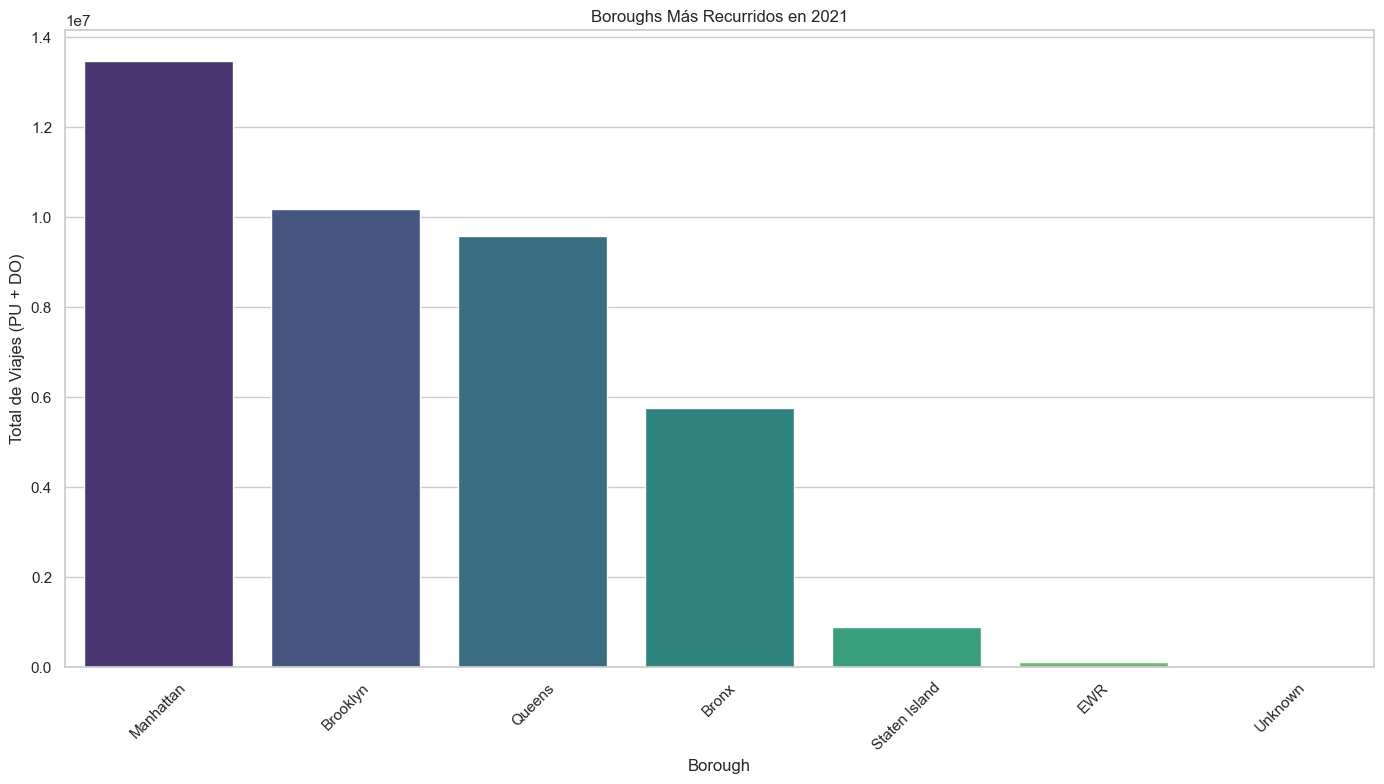

In [9]:
# Contar las ocurrencias de cada PULocationID y DOLocationID
pulocation_counts = full_df['PULocationID'].value_counts().reset_index()
dolocation_counts = full_df['DOLocationID'].value_counts().reset_index()

# Renombrar las columnas para claridad
pulocation_counts.columns = ['LocationID', 'PUCount']
dolocation_counts.columns = ['LocationID', 'DOCount']

# Unir los conteos con el archivo de lookup de zonas de taxi
location_counts = pd.merge(pulocation_counts, dolocation_counts, on='LocationID', how='outer').fillna(0)
location_counts['TotalCount'] = location_counts['PUCount'] + location_counts['DOCount']
location_counts = pd.merge(location_counts, taxi_zones, left_on='LocationID', right_on='LocationID', how='left')

# Agrupar por borough y sumar los conteos
borough_counts = location_counts.groupby('Borough')['TotalCount'].sum().reset_index()

# Ordenar por TotalCount
borough_counts = borough_counts.sort_values(by='TotalCount', ascending=False)

# Mostrar los boroughs más recurridos
print(borough_counts)

# Crear un gráfico de los boroughs más recurridos
plt.figure(figsize=(14, 8))
sns.barplot(data=borough_counts, x='Borough', y='TotalCount', palette='viridis')
plt.title('Boroughs Más Recurridos en 2021')
plt.xlabel('Borough')
plt.ylabel('Total de Viajes (PU + DO)')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [10]:
# Asegurarse de que la columna pickup_datetime sea de tipo datetime
full_df['date'] = pd.to_datetime(full_df['date'])

# Agregar columnas para el día de la semana y la semana del año
full_df['day_of_week'] = full_df['date'].dt.day_name()
full_df['week_of_year'] = full_df['date'].dt.isocalendar().week

Días de la Semana con Más Viajes:
   DayOfWeek  TripCount
0   Saturday    3074126
1     Friday    3023024
2     Sunday    2919980
3   Thursday    2846829
4  Wednesday    2804136
5    Tuesday    2735803
6     Monday    2702796

Semanas con Más Viajes:
    WeekOfYear  TripCount
0           24     403237
1           12     402865
2           13     402821
3           25     402505
4           11     402318
5           20     400729
6           14     399791
7           35     399494
8           36     398959
9           22     398916
10          32     398193
11          23     397751
12          16     397219
13          28     397181
14          27     397056
15          17     397043
16          30     396364
17          15     395630
18          31     395593
19          34     395091
20          29     395088
21          37     394698
22          21     393750
23          18     393742
24          26     393270
25          19     391349
26          10     390635
27          38     39

C:\Users\castr\AppData\Local\Temp\ipykernel_17220\215077887.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=day_of_week_counts, x='DayOfWeek', y='TripCount', palette='viridis')


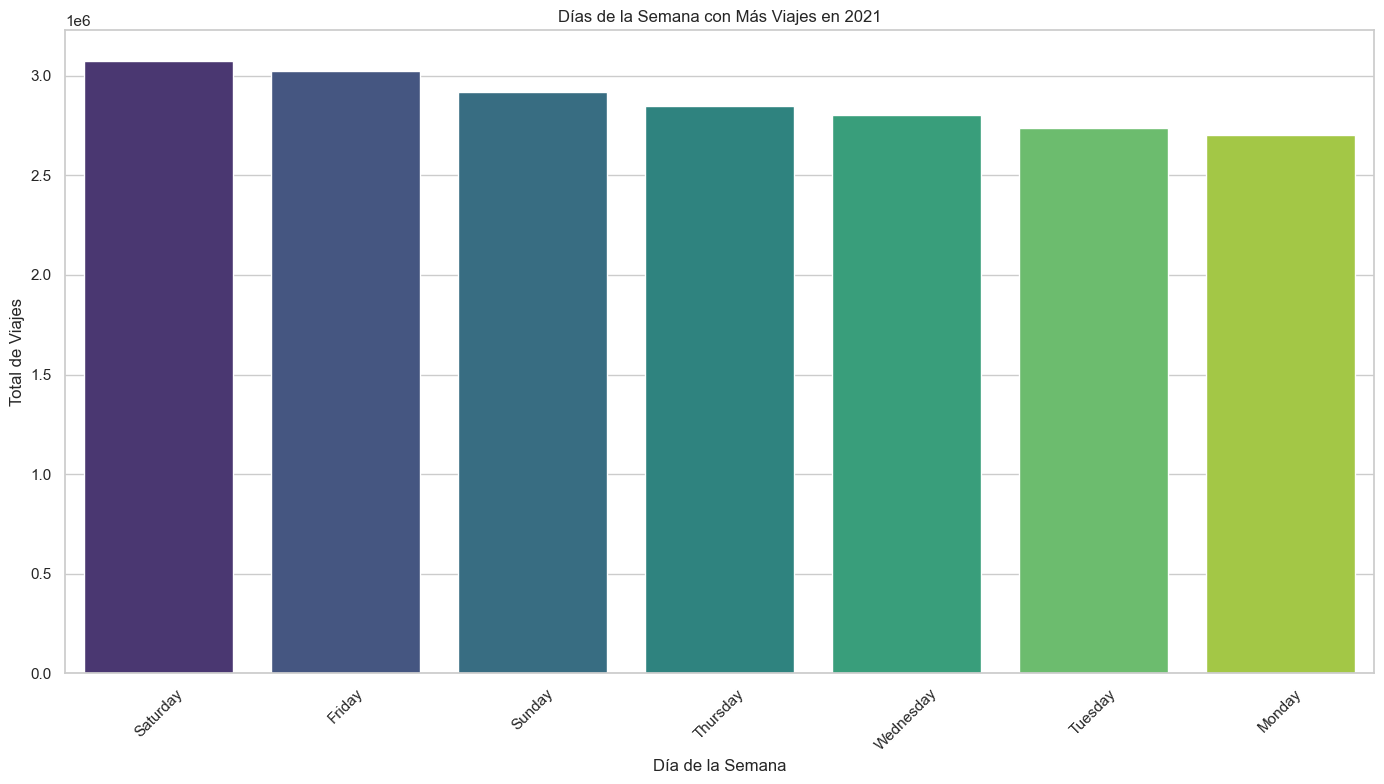

C:\Users\castr\AppData\Local\Temp\ipykernel_17220\215077887.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=week_of_year_counts, x='WeekOfYear', y='TripCount', palette='viridis')


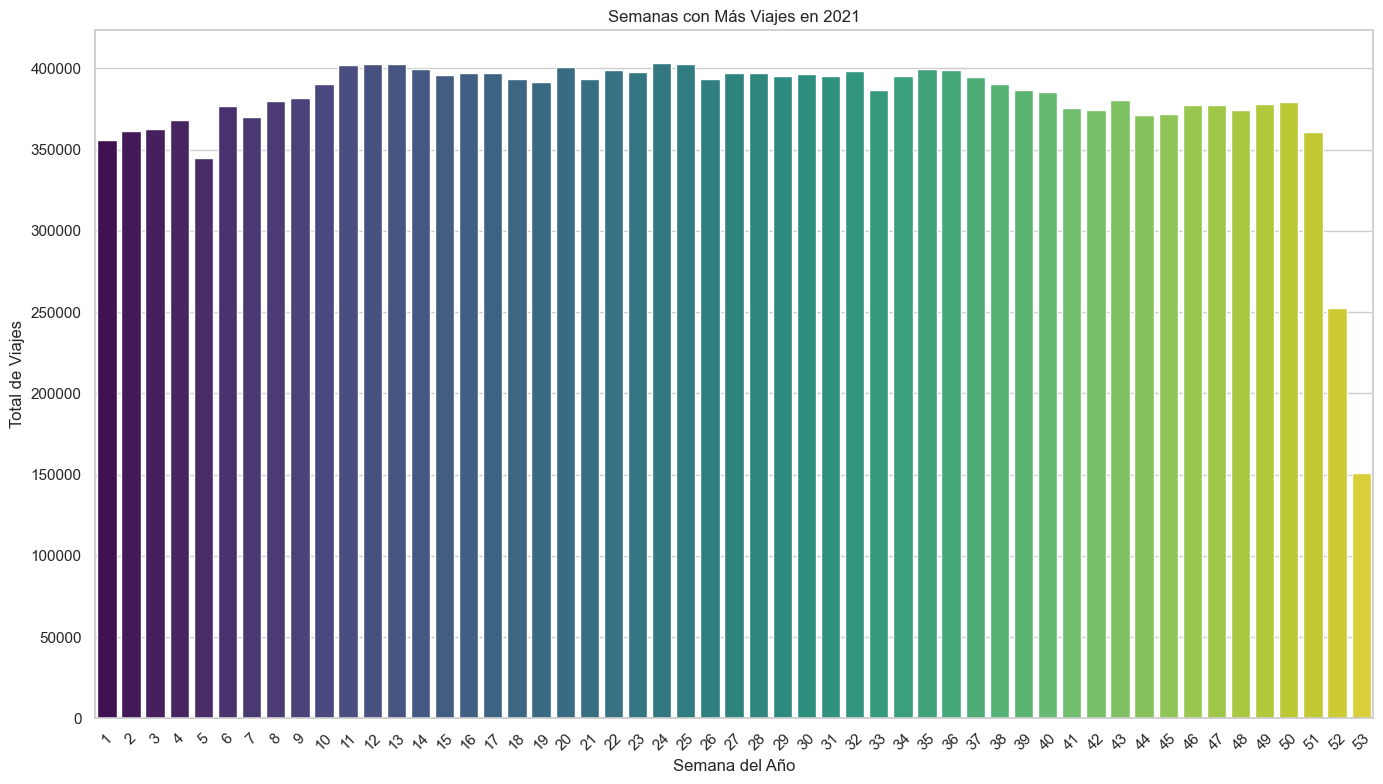

In [11]:
# Contar los viajes por día de la semana
day_of_week_counts = full_df['day_of_week'].value_counts().reset_index()
day_of_week_counts.columns = ['DayOfWeek', 'TripCount']
day_of_week_counts = day_of_week_counts.sort_values(by='TripCount', ascending=False)

# Contar los viajes por semana del año
week_of_year_counts = full_df['week_of_year'].value_counts().reset_index()
week_of_year_counts.columns = ['WeekOfYear', 'TripCount']
week_of_year_counts = week_of_year_counts.sort_values(by='TripCount', ascending=False)

# Mostrar los días de la semana con más viajes
print("Días de la Semana con Más Viajes:")
print(day_of_week_counts)

# Mostrar las semanas con más viajes
print("\nSemanas con Más Viajes:")
print(week_of_year_counts)

# Crear un gráfico de los días de la semana con más viajes
plt.figure(figsize=(14, 8))
sns.barplot(data=day_of_week_counts, x='DayOfWeek', y='TripCount', palette='viridis')
plt.title('Días de la Semana con Más Viajes en 2021')
plt.xlabel('Día de la Semana')
plt.ylabel('Total de Viajes')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Crear un gráfico de las semanas con más viajes
plt.figure(figsize=(14, 8))
sns.barplot(data=week_of_year_counts, x='WeekOfYear', y='TripCount', palette='viridis')
plt.title('Semanas con Más Viajes en 2021')
plt.xlabel('Semana del Año')
plt.ylabel('Total de Viajes')
plt.xticks(rotation=45)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [13]:
# Unir los datos de las locaciones con los boroughs
full_df = full_df.merge(taxi_zones[['LocationID', 'Borough']], left_on='PULocationID', right_on='LocationID', how='left')
full_df = full_df.rename(columns={'Borough': 'PUBorough'}).drop('LocationID', axis=1)

full_df = full_df.merge(taxi_zones[['LocationID', 'Borough']], left_on='DOLocationID', right_on='LocationID', how='left')
full_df = full_df.rename(columns={'Borough': 'DOBorough'}).drop('LocationID', axis=1)

# Determinar si el viaje es intra-borough o inter-borough
full_df['TripType'] = full_df.apply(lambda row: 'Intra-Borough' if row['PUBorough'] == row['DOBorough'] else 'Inter-Borough', axis=1)

Viajes Inter e Intra Boroughs:
        TripType  TripCount
0  Inter-Borough   11625797
1  Intra-Borough    8480897


C:\Users\castr\AppData\Local\Temp\ipykernel_17220\2127094968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trip_type_counts, x='TripType', y='TripCount', palette='viridis')


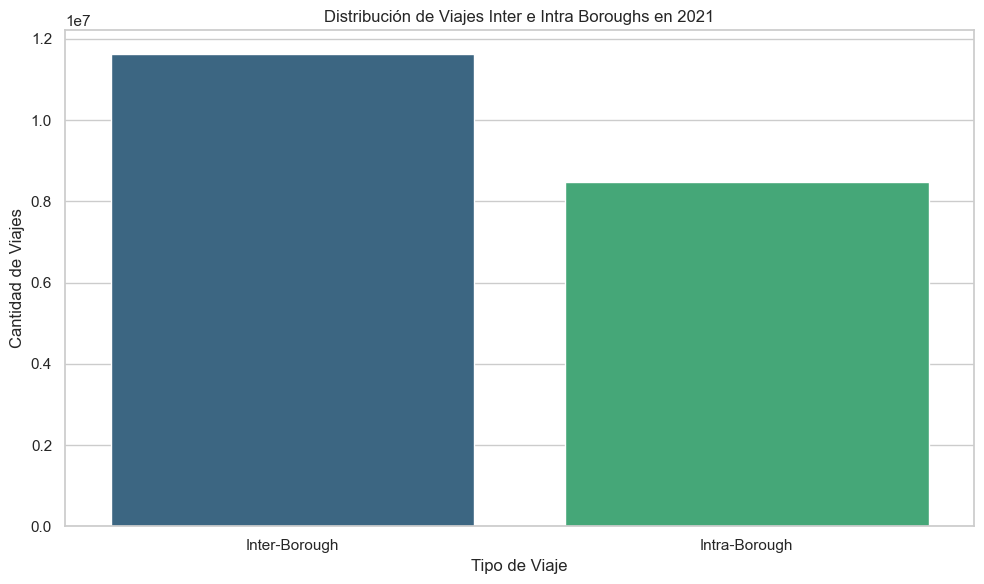

In [14]:
# Contar los viajes por tipo
trip_type_counts = full_df['TripType'].value_counts().reset_index()
trip_type_counts.columns = ['TripType', 'TripCount']

# Mostrar los resultados
print("Viajes Inter e Intra Boroughs:")
print(trip_type_counts)

# Crear un gráfico de los viajes inter e intra boroughs
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=trip_type_counts, x='TripType', y='TripCount', palette='viridis')
plt.title('Distribución de Viajes Inter e Intra Boroughs en 2021')
plt.xlabel('Tipo de Viaje')
plt.ylabel('Cantidad de Viajes')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [24]:
full_df

,date,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tips,driver_pay,hvfhs_license_num,day_of_week,week_of_year,PUBorough,DOBorough,TripType,hour_of_day
0,2021-01-01,2,181,11.020,2407,46.44,0.00,32.58,Uber,Friday,53,Queens,Brooklyn,Inter-Borough,0
1,2021-01-01,3,3,52.860,13549,336.67,3.76,284.84,Uber,Friday,53,Bronx,Bronx,Intra-Borough,0
2,2021-01-01,3,7,25.560,3934,100.95,0.00,76.54,Uber,Friday,53,Bronx,Queens,Inter-Borough,0
3,2021-01-01,3,18,97.960,24503,487.42,2.82,373.61,Uber,Friday,53,Bronx,Bronx,Intra-Borough,0
4,2021-01-01,3,20,62.590,14135,276.95,10.34,215.38,Uber,Friday,53,Bronx,Bronx,Intra-Borough,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20106689,2021-12-31,265,203,1.246,296,8.27,0.00,5.47,Lyft,Friday,52,NaN,Queens,Inter-Borough,0
20106690,2021-12-31,265,241,6.179,1056,19.86,0.00,15.70,Lyft,Friday,52,NaN,Bronx,Inter-Borough,0
20106691,2021-12-31,265,254,4.135,1400,28.53,0.00,16.31,Lyft,Friday,52,NaN,Bronx,Inter-Borough,0
20106692,2021-12-31,265,259,1.031,412,9.15,0.00,5.47,Lyft,Friday,52,NaN,Bronx,Inter-Borough,0


Cantidad de Viajes entre Conexiones de Boroughs:
DOBorough        Bronx  Brooklyn  Manhattan   Queens  Staten Island
PUBorough                                                          
Bronx          1107288    280430    1000799   458432           8294
Brooklyn        285990   2109538    1504341  1025891         130436
Manhattan       990918   1498216    2968886  1149340          76583
Queens          467036   1040655    1156183  2088066          26247
Staten Island     7981    130074      62991    25389         207093


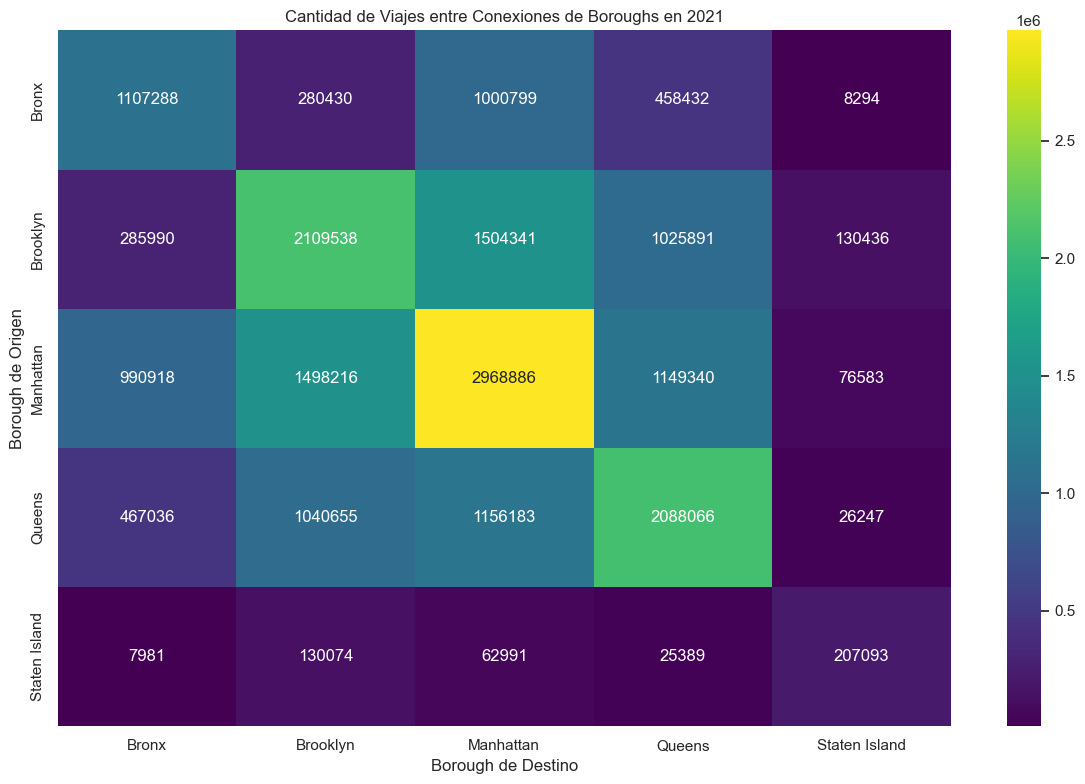

In [19]:
# Filtrar full_df para excluir 'Unknown' y 'EWR' en las columnas PUBorough y DOBorough
filtered_df = full_df[~full_df['PUBorough'].isin(['Unknown', 'EWR']) & ~full_df['DOBorough'].isin(['Unknown', 'EWR'])]

# Crear una tabla pivote para contar los viajes entre conexiones de boroughs
borough_connections = pd.pivot_table(filtered_df, 
                                     index='PUBorough', columns='DOBorough', 
                                     aggfunc='size', fill_value=0)

# Mostrar la tabla de conexiones de boroughs
print("Cantidad de Viajes entre Conexiones de Boroughs:")
print(borough_connections)

# Crear un heatmap de las conexiones de boroughs
plt.figure(figsize=(12, 8))
sns.heatmap(borough_connections, annot=True, fmt='d', cmap='viridis', cbar=True)
plt.title('Cantidad de Viajes entre Conexiones de Boroughs en 2021')
plt.xlabel('Borough de Destino')
plt.ylabel('Borough de Origen')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

C:\Users\castr\AppData\Local\Temp\ipykernel_17220\1690443058.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_combinations['combination'] = top_combinations.apply(lambda row: f"{row['PULocationID']} -> {row['DOLocationID']}", axis=1)
C:\Users\castr\AppData\Local\Temp\ipykernel_17220\1690443058.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='counts', y='combination', data=top_combinations, palette='viridis')


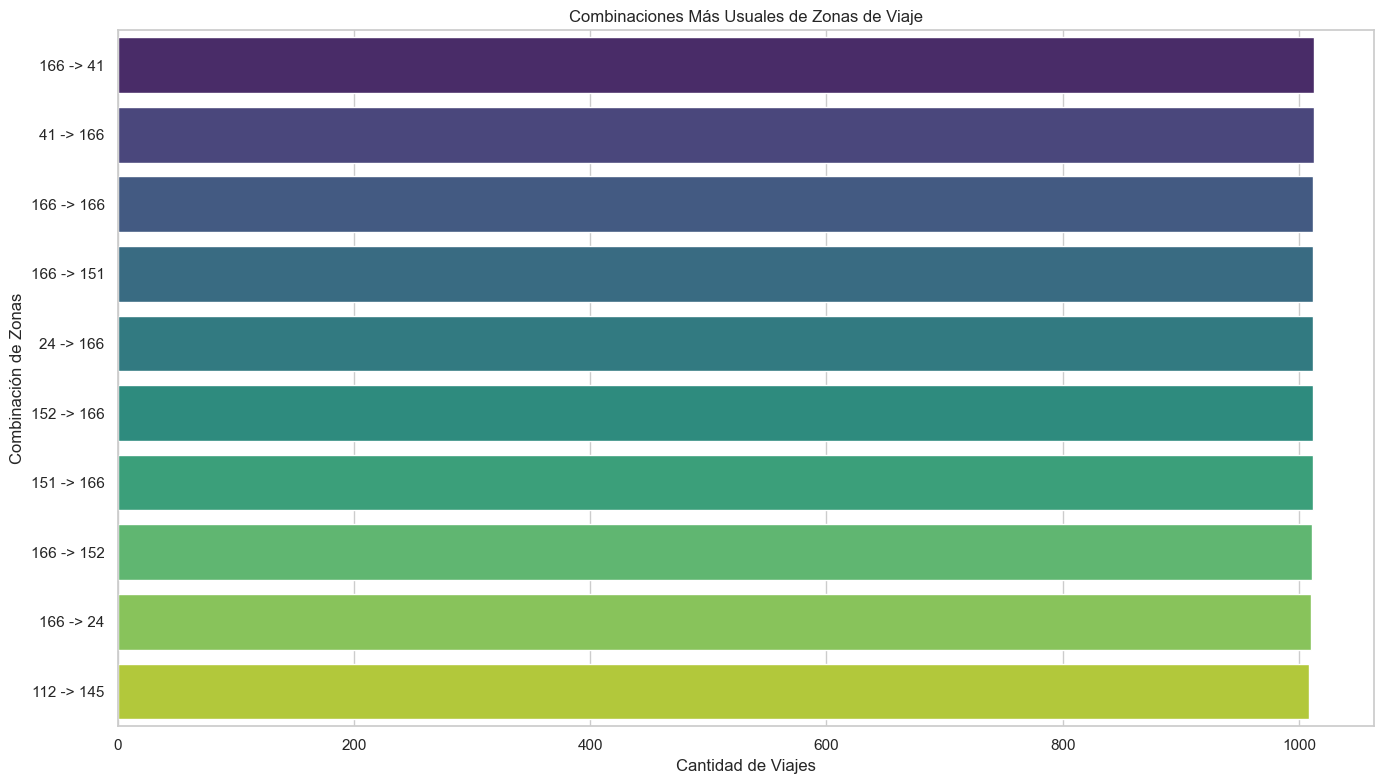

In [34]:
# Calcular las combinaciones más usuales de zonas de viaje
combinations_df = full_df_cleaned.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='counts')
combinations_df = combinations_df.sort_values(by='counts', ascending=False)

# Seleccionar las 10 combinaciones más comunes
top_combinations = combinations_df.head(10)

# Crear etiquetas para las combinaciones
top_combinations['combination'] = top_combinations.apply(lambda row: f"{row['PULocationID']} -> {row['DOLocationID']}", axis=1)

# Graficar las combinaciones más comunes
plt.figure(figsize=(14, 8))
sns.barplot(x='counts', y='combination', data=top_combinations, palette='viridis')
plt.title('Combinaciones Más Usuales de Zonas de Viaje')
plt.xlabel('Cantidad de Viajes')
plt.ylabel('Combinación de Zonas')
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [35]:
full_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19921606 entries, 0 to 20106680
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   PULocationID         int64         
 2   DOLocationID         int64         
 3   trip_miles           float64       
 4   trip_time            int64         
 5   base_passenger_fare  float64       
 6   tips                 float64       
 7   driver_pay           float64       
 8   hvfhs_license_num    object        
 9   day_of_week          object        
 10  week_of_year         UInt32        
 11  PUBorough            object        
 12  DOBorough            object        
 13  TripType             object        
 14  hour_of_day          int32         
dtypes: UInt32(1), datetime64[ns](1), float64(4), int32(1), int64(3), object(5)
memory usage: 2.2+ GB
